## Paper

https://arxiv.org/pdf/1812.07627.pdf

## Repository

https://github.com/kiankd/corel2019

## Silhouette Loss

https://platform.ai/blog/page/11/the-silhouette-loss-function-metric-learning-with-a-cluster-validity-index/

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [392]:
# Helper functions for dealing with AR Loss
def get_armask(shape, labels):
    if labels.dtype != tf.int32:
        raise Exception("Labels must be a LongTensor with dtype=int32!")

    mask = tf.zeros(shape)
    arr = tf.range(0, shape[0], 1)

    # want to maximize similarity to the correct classes, so this is negative.
#     mask = - 1.
    mask_arr = tf.cast(tf.math.equal(tf.reshape(arr, (-1, 1)), labels), "float32")
    mask = mask + (mask_arr * - 1.)
    return mask

def arloss(attraction_tensor, repulsion_tensor, lam):
    # combine up everything to accumulate across the entire batch
    loss_attraction = tf.reduce_sum(attraction_tensor)
    loss_repulsion = tf.reduce_sum(repulsion_tensor)
    arloss = (lam * loss_attraction) + ((1. - lam) * loss_repulsion)
    return arloss / tf.cast(tf.shape(attraction_tensor)[0], 'float32')

In [28]:
# Gaussian-COREL combined loss function
def GaussianARLoss(inputs):

    labels     = inputs[:, :1]
    labels     = tf.cast(labels, dtype='int32')
    embeddings =  tf.cast(inputs[:, 1:], dtype='float32')
    lam=0.5
    mask = get_armask(tf.shape(embeddings), labels)
    # in this case, use standard LogSoftmax, without AR.
    if lam == 0.5:
        softmax_predictions = tf.nn.log_softmax(embeddings, axis=1)
        loss_tensor = mask * softmax_predictions
        return tf.reduce_mean(loss_tensor)

    # otherwise, do it in the slightly less numerically stable way.
    attraction_tensor = mask * predictions * self.lam
    repulsion_tensor = tf.exp(predictions)
    repulsion_tensor = tf.log(tf.reduce_sum(repulsion_tensor, axis=1) + 1e-10) * (1. - lam)
    return arloss(attraction_tensor, repulsion_tensor, lam)

### Gausian-COREL loss

In [4]:
v = tf.constant([[1.0, 2.0, 2.0], [2.0, 3.0, 4.0], [1.0, 1.5, 2.0], 
                 [1.0, 1.0, 2.0], [3.0, 1.0, 4.0], [3.0, 1.0, 2.0]]) # [2, 3.0, 4.0] [1, 1.0, 2.0]
tl_loss = GaussianARLoss(v)
sess=tf.Session() 
sess.run(tl_loss)

0.0

### Cosine-COREL loss

In [74]:
def CosineARLoss(inputs):
    labels = inputs[:, :1]
    labels = tf.cast(labels, dtype='int32')
    embeddings =  tf.cast(inputs[:, 1:], dtype='float32')
    lam=0.5
    
    mask = get_armask(tf.shape(embeddings), labels)

    # make the attractor and repulsor, mask them!
    attraction_tensor = mask * embeddings
    repulsion_tensor = (mask + 1.0) * embeddings

    # now, apply the special cosine-COREL rules, taking the argmax and squaring the repulsion
    return attraction_tensor
    repulsion_tensor = tf.reduce_max(repulsion_tensor, axis=1)
    repulsion_tensor = repulsion_tensor ** 2

    return arloss(attraction_tensor, repulsion_tensor, lam)

In [27]:
v = tf.constant([[1.0, 2.0, 2.0], [2.0, 3.0, 4.0], [1.0, 1.5, 2.0], 
                 [1.0, 1.0, 2.0], [3.0, 1.0, 4.0], [3.0, 1.0, 2.0]]) # [2, 3.0, 4.0] [1, 1.0, 2.0]
tl_loss = CosineARLoss(v)
sess=tf.Session() 
sess.run(tl_loss)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

### Auxiliary functions to plot latent space

In [786]:
from sklearn.manifold import TSNE
import time
def create_tsne(model, X):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(model.predict(X))
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

In [788]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(classes, tsne_results):
    df_subset = {}
    df_subset['y'] = classes
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", N_classes),
        data=df_subset,
        legend="full",
        alpha=0.6
    )

In [206]:
def cosine_similarity(y_true, y_pred):
    return tf.reduce_mean(y_pred[::, 1])

In [838]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

### Reuters newswire classification dataset

In [1140]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(
    path="reuters.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)

N_classes = len(set(y_test))
N_samples = len(x_train)
# N_samples = 32
labels = mlb.fit_transform(y_train.reshape(-1, 1).tolist())
classes = y_train
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=100, truncating='post')
D_input   = len(x_train_pad[0])
X = np.asarray([x.tolist() for x in x_train_pad])

### Make synthetic data

In [902]:
# params for synthetic data
N_epochs = 100
N_classes = 10
N_samples = 500
D_input = 16 # dimensionality of input samples
# model params
D_reps = 30 # dimensionality of the hidden representations

# make the synthetic data
X_data = np.random.rand(N_samples, D_input) * 10.
labels = np.asarray([i % N_classes for i in range(N_samples)])
classes = labels
labels = mlb.fit_transform(labels.reshape(-1, 1).tolist())
X = X_data

https://martin-thoma.com/nlp-reuters/

#### Build model

In [1141]:
# Inputs
# input_labels = Input(shape=(1, ), name='input_label')    # input layer for labels
input_features = Input(shape=(D_input, ), name='input_features')
inputs = input_features #[input_labels, input_features]

# Hidden layers
hidden_layer = input_features
# for units in [64, 32]:
#     hidden_layer = Dense(units, activation='tanh', kernel_initializer='random_uniform')(hidden_layer)
x = Dense(256, activation="relu")(hidden_layer)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(N_classes)(x)
hidden_layer = Activation("sigmoid")(x)
encoded_model = Model(inputs = inputs, outputs = hidden_layer, name = 'Encoded_Model')

#cosine_layer = CosineLayer(N_classes)(encoded_model.output)
# hidden_layer =  encoded_model.output
output = hidden_layer #concatenate([input_labels, cosine_layer])  # concatenating the labels + embeddings
model = Model(inputs, output, name = 'Similarity_Model')
# setup the optimization process 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 100)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 256)               25856     
_________________________________________________________________
dropout_95 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_339 (Dense)            (None, 46)                11822     
_________________________________________________________________
activation_30 (Activation)   (None, 46)                0         
Total params: 103,470
Trainable params: 103,470
Non-trainable params: 0
_________________________________________________________________


In [1142]:
model.fit(x=X, y=labels, batch_size=N_samples, epochs=500)

Epoch 1/500
8982/8982 [==============================] - 4s 450us/step - loss: 8.9687 - acc: 0.0458
Epoch 2/500
8982/8982 [==============================] - 0s 4us/step - loss: 6.8221 - acc: 0.0659
Epoch 3/500
8982/8982 [==============================] - 0s 4us/step - loss: 5.9511 - acc: 0.0675
Epoch 4/500
8982/8982 [==============================] - 0s 4us/step - loss: 5.4169 - acc: 0.0638
Epoch 5/500
8982/8982 [==============================] - 0s 4us/step - loss: 5.0742 - acc: 0.0623
Epoch 6/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.8301 - acc: 0.0589
Epoch 7/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.6872 - acc: 0.0571
Epoch 8/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.5987 - acc: 0.0529
Epoch 9/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.5066 - acc: 0.0512
Epoch 10/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.3534 - acc: 0.0499
Epoch 11/500
8982

Epoch 84/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0207 - acc: 0.0480
Epoch 85/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0291 - acc: 0.0480
Epoch 86/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0374 - acc: 0.0479
Epoch 87/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0322 - acc: 0.0481
Epoch 88/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0336 - acc: 0.0481
Epoch 89/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0118 - acc: 0.0481
Epoch 90/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0288 - acc: 0.0481
Epoch 91/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0254 - acc: 0.0480
Epoch 92/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0129 - acc: 0.0480
Epoch 93/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0276 - acc: 0.0481
Epoch 94/5

8982/8982 [==============================] - 0s 4us/step - loss: 4.0300 - acc: 0.0481
Epoch 167/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0143 - acc: 0.0481
Epoch 168/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9989 - acc: 0.0480
Epoch 169/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0156 - acc: 0.0479
Epoch 170/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0141 - acc: 0.0481
Epoch 171/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0068 - acc: 0.0480
Epoch 172/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0072 - acc: 0.0481
Epoch 173/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0161 - acc: 0.0481
Epoch 174/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0128 - acc: 0.0481
Epoch 175/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0140 - acc: 0.0480
Epoch 176/500


8982/8982 [==============================] - 0s 4us/step - loss: 4.0018 - acc: 0.0481
Epoch 249/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9976 - acc: 0.0481
Epoch 250/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0025 - acc: 0.0481
Epoch 251/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0089 - acc: 0.0481
Epoch 252/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9983 - acc: 0.0481
Epoch 253/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0071 - acc: 0.0481
Epoch 254/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0131 - acc: 0.0481
Epoch 255/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0000 - acc: 0.0481
Epoch 256/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9952 - acc: 0.0481
Epoch 257/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0051 - acc: 0.0481
Epoch 258/500


8982/8982 [==============================] - 0s 4us/step - loss: 3.9901 - acc: 0.0481
Epoch 331/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9852 - acc: 0.0481
Epoch 332/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9884 - acc: 0.0481
Epoch 333/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9848 - acc: 0.0481
Epoch 334/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9968 - acc: 0.0481
Epoch 335/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9877 - acc: 0.0481
Epoch 336/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9978 - acc: 0.0481
Epoch 337/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9945 - acc: 0.0481
Epoch 338/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9891 - acc: 0.0481
Epoch 339/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9899 - acc: 0.0481
Epoch 340/500


8982/8982 [==============================] - 0s 4us/step - loss: 3.9891 - acc: 0.0481
Epoch 413/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0003 - acc: 0.0481
Epoch 414/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9939 - acc: 0.0481
Epoch 415/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9883 - acc: 0.0481
Epoch 416/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0095 - acc: 0.0481
Epoch 417/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0036 - acc: 0.0481
Epoch 418/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9840 - acc: 0.0481
Epoch 419/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9986 - acc: 0.0481
Epoch 420/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9971 - acc: 0.0481
Epoch 421/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9815 - acc: 0.0481
Epoch 422/500


8982/8982 [==============================] - 0s 4us/step - loss: 4.0105 - acc: 0.0481
Epoch 495/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9911 - acc: 0.0481
Epoch 496/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0080 - acc: 0.0481
Epoch 497/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0108 - acc: 0.0481
Epoch 498/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9953 - acc: 0.0481
Epoch 499/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.0106 - acc: 0.0481
Epoch 500/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.9983 - acc: 0.0481


In [1143]:
encoded_model.predict(X).shape

(8982, 46)

In [1144]:
tsne_results_cce = create_tsne(encoded_model, X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8982 samples in 0.084s...
[t-SNE] Computed neighbors for 8982 samples in 3.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8982
[t-SNE] Computed conditional probabilities for sample 2000 / 8982
[t-SNE] Computed conditional probabilities for sample 3000 / 8982
[t-SNE] Computed conditional probabilities for sample 4000 / 8982
[t-SNE] Computed conditional probabilities for sample 5000 / 8982
[t-SNE] Computed conditional probabilities for sample 6000 / 8982
[t-SNE] Computed conditional probabilities for sample 7000 / 8982
[t-SNE] Computed conditional probabilities for sample 8000 / 8982
[t-SNE] Computed conditional probabilities for sample 8982 / 8982
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.018799
[t-SNE] Error after 300 iterations: 1.080063
t-SNE done! Time elapsed: 54.15117287635803 seconds


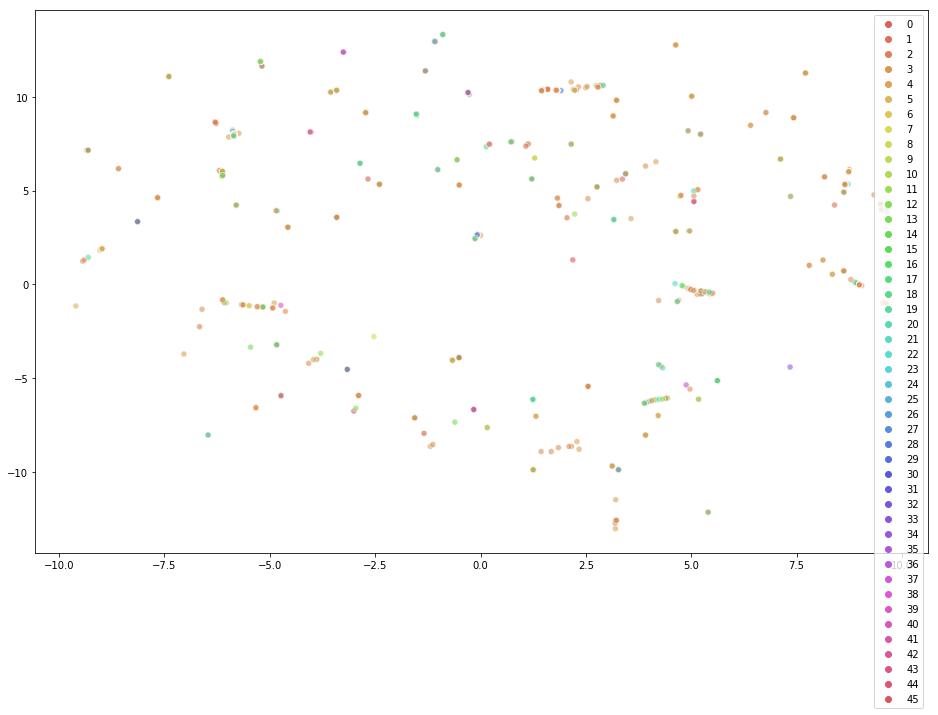

In [1145]:
plot_clusters(classes, tsne_results_cce)

## AR loss

In [1131]:
from keras.layers import Layer, Dense, Input, Dot, concatenate, Lambda, Activation, Dropout
from keras.models import Model
import numpy as np
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x_norm = tf.norm(x)
    y_norm = tf.norm(y)
    return K.dot(x, y) / ( x_norm * y_norm )
def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def custom_loss(y_true, y_pred):
    return K.mean(y_pred)

class CosineLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CosineLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='cosine_weight', 
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer="random_normal",
                                      trainable=True)
#         print("Shape input ", input_shape)
#         print("Shape weight ", (K.int_shape(self.W)))
        super(CosineLayer, self).build(input_shape)  # Be sure to call this at the end
        
    def call(self, x):
        # Normalize X
#         x_min = tf.reduce_min(x)
#         x_max = tf.reduce_max(x)
#         x_norm = (x - x_min) / (x_max - x_min)
#         # Normalize weight
#         w_min = tf.reduce_min(self.W)
#         w_max = tf.reduce_max(self.W)
#         w_norm = (self.W - w_min) / (w_max - w_min)
#         print(K.int_shape(x_norm), K.shape(x_norm))
#         print(K.int_shape(w_norm), K.shape(w_norm))
        return Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x, self.W])
#         return tf.matmul(x_norm, w_norm)
        #print("Output ", K.int_shape(Dot(axes=1,normalize=True)([x, tf.transpose(self.W)])))
        #return Dot(axes=1,normalize=False)([x, self.W])
        #return tf.keras.backend.dot(x_norm, w_norm, axis=1)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [1132]:
# Helper functions for dealing with AR Loss
def get_armask(shape, labels):
    if labels.dtype != tf.float32:
        raise Exception("Labels must be a LongTensor with dtype=int32!")
    #mask = tf.zeros(shape)
    #arr = tf.range(0, shape[0], 1)
    mask = tf.identity(labels)
    mask = mask * -1.

    # want to maximize similarity to the correct classes, so this is negative.
    #mask = mask * - 1.
    #mask_arr = tf.cast(tf.math.equal(tf.reshape(arr, (-1, 1)), labels), "float32")
    #mask = mask + (mask_arr * - 1.)
    return mask

def arloss(attraction_tensor, repulsion_tensor, lam):
    # combine up everything to accumulate across the entire batch
    loss_attraction = tf.reduce_sum(attraction_tensor)
    loss_repulsion = tf.reduce_sum(repulsion_tensor)
    arloss = (lam * loss_attraction) + ((1. - lam) * loss_repulsion)
    return arloss / tf.cast(tf.shape(attraction_tensor)[0], 'float32')

def CosineARLoss(y_true, y_pred):
#     inputs = y_pred
#     labels = inputs[:, :1]
    y_true = tf.cast(labels, dtype='float32')
#     embeddings = tf.cast(inputs[:, 1:], dtype='float32')
    lam=0.5
    
    mask = get_armask(tf.shape(y_pred), y_true)

    # make the attractor and repulsor, mask them!
    attraction_tensor = mask * y_pred
    repulsion_tensor = (mask + 1) * y_pred

    # now, apply the special cosine-COREL rules, taking the argmax and squaring the repulsion
    repulsion_tensor = tf.cast(tf.math.argmax(repulsion_tensor, axis=1), 'float32')
    repulsion_tensor = repulsion_tensor ** 2

    return arloss(attraction_tensor, repulsion_tensor, lam)

In [1133]:
# Inputs
# input_labels = Input(shape=(1, ), name='input_label')    # input layer for labels
input_features = Input(shape=(D_input, ), name='input_features')
inputs = input_features #[input_labels, input_features]

# Hidden layers
hidden_layer = input_features
# for units in [64, 32]:
#     hidden_layer = Dense(units, activation='tanh', kernel_initializer='random_uniform')(hidden_layer)
x = Dense(256, activation="relu")(hidden_layer)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
# hidden_layer = CosineLayer(N_classes)(x)
x = Dense(N_classes)(x)
hidden_layer = Activation("sigmoid")(x)
encoded_model = Model(inputs = inputs, outputs = hidden_layer, name = 'Encoded_Model')

#cosine_layer = CosineLayer(N_classes)(encoded_model.output)
# hidden_layer =  encoded_model.output
output = hidden_layer #concatenate([input_labels, cosine_layer])  # concatenating the labels + embeddings
model = Model(inputs, output, name = 'Similarity_Model')
# setup the optimization process 
model.compile(optimizer='adam', loss=CosineARLoss, metrics=['accuracy']) # CosineARLoss

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 100)               0         
_________________________________________________________________
dense_334 (Dense)            (None, 256)               25856     
_________________________________________________________________
dropout_94 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_335 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_336 (Dense)            (None, 46)                11822     
_________________________________________________________________
activation_29 (Activation)   (None, 46)                0         
Total params: 103,470
Trainable params: 103,470
Non-trainable params: 0
_________________________________________________________________


In [1137]:
model.fit(x=X, y=labels, batch_size=N_samples, epochs=500)

Epoch 1/500
8982/8982 [==============================] - 0s 4us/step - loss: 4.8758 - acc: 0.0452
Epoch 2/500
8982/8982 [==============================] - 0s 4us/step - loss: 3.3158 - acc: 0.0633
Epoch 3/500
8982/8982 [==============================] - 0s 4us/step - loss: 2.1546 - acc: 0.0718
Epoch 4/500
8982/8982 [==============================] - 0s 4us/step - loss: 1.3448 - acc: 0.0716
Epoch 5/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.8326 - acc: 0.0613
Epoch 6/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.6485 - acc: 0.0557
Epoch 7/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.4195 - acc: 0.0524
Epoch 8/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.3160 - acc: 0.0488
Epoch 9/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.2478 - acc: 0.0489
Epoch 10/500
8982/8982 [==============================] - 0s 4us/step - loss: 0.1948 - acc: 0.0478
Epoch 11/500
8982/8

Epoch 84/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4934 - acc: 0.0061
Epoch 85/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0061
Epoch 86/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0061
Epoch 87/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4931 - acc: 0.0061
Epoch 88/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4943 - acc: 0.0062
Epoch 89/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4938 - acc: 0.0065
Epoch 90/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4934 - acc: 0.0061
Epoch 91/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4934 - acc: 0.0062
Epoch 92/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4933 - acc: 0.0063
Epoch 93/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4932 - acc: 0.0066


Epoch 166/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4938 - acc: 0.0066
Epoch 167/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4936 - acc: 0.0062
Epoch 168/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0061
Epoch 169/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4938 - acc: 0.0061
Epoch 170/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0062
Epoch 171/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4937 - acc: 0.0063
Epoch 172/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4941 - acc: 0.0065
Epoch 173/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4936 - acc: 0.0061
Epoch 174/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4935 - acc: 0.0063
Epoch 175/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4930 - ac

8982/8982 [==============================] - 0s 4us/step - loss: -0.4938 - acc: 0.0063
Epoch 248/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4944 - acc: 0.0061
Epoch 249/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0062
Epoch 250/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0062
Epoch 251/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4945 - acc: 0.0061
Epoch 252/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4941 - acc: 0.0063
Epoch 253/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4948 - acc: 0.0061
Epoch 254/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4937 - acc: 0.0062
Epoch 255/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4947 - acc: 0.0062
Epoch 256/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4940 - acc: 0.0061
Epoc

Epoch 329/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 330/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4959 - acc: 0.0061
Epoch 331/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 332/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 333/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 334/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 335/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 336/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 337/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 338/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - ac

8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 411/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 412/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 413/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 414/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 415/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 416/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 417/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 418/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 419/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoc

Epoch 492/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 493/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 494/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 495/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 496/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 497/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061
Epoch 498/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 499/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4961 - acc: 0.0061
Epoch 500/500
8982/8982 [==============================] - 0s 4us/step - loss: -0.4960 - acc: 0.0061


In [1138]:
tsne_results_ar = create_tsne(encoded_model, X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8982 samples in 0.114s...
[t-SNE] Computed neighbors for 8982 samples in 4.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8982
[t-SNE] Computed conditional probabilities for sample 2000 / 8982
[t-SNE] Computed conditional probabilities for sample 3000 / 8982
[t-SNE] Computed conditional probabilities for sample 4000 / 8982
[t-SNE] Computed conditional probabilities for sample 5000 / 8982
[t-SNE] Computed conditional probabilities for sample 6000 / 8982
[t-SNE] Computed conditional probabilities for sample 7000 / 8982
[t-SNE] Computed conditional probabilities for sample 8000 / 8982
[t-SNE] Computed conditional probabilities for sample 8982 / 8982
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.836838
[t-SNE] Error after 300 iterations: 3.771302
t-SNE done! Time elapsed: 69.13642311096191 seconds


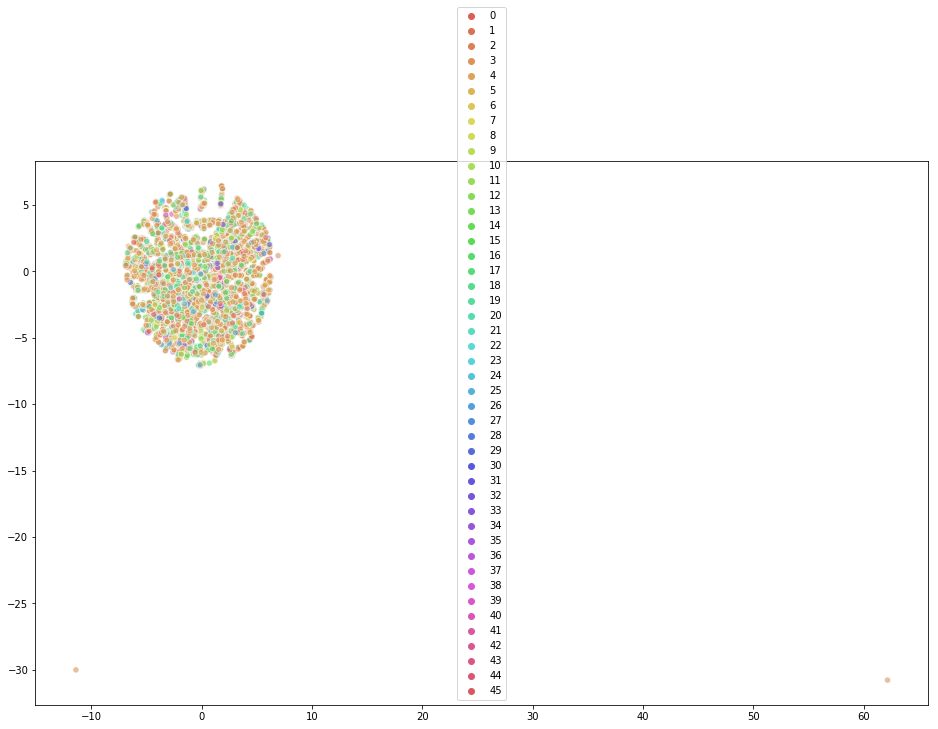

In [1139]:
plot_clusters(classes, tsne_results_ar)